In [1]:
import numpy as np
import math
import pandas as pd
from collections import Counter
import pickle
from genchar import *
import glob
import os
import yaml
import plotnine as pn
import seaborn as sn
from matplotlib.colors import LogNorm
import matplotlib.cbook
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
%load_ext rpy2.ipython

* Project '~/Projects/tumor-deconvolution-dream-challenge/scripts' loaded. [renv 0.7.0-131]


R[write to console]: Warning message:

R[write to console]: Project requested R version '3.5.2' but '3.6.1' is currently being used 

R[write to console]: During startup - 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘nvimcom’

R[write to console]: 2: package ‘nvimcom’ in options("defaultPackages") was not found 

R[write to console]: 3: 
R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘colorout’

R[write to console]: 4: package ‘colorout’ in options("defaultPackages") was not found 

/homes/olymp/dominik.otto/.conda/envs/condaEnv/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed 

This is done in `genchar.py` and saved in `../../data/genchar_coarse_unclean.pkl`:
```
grain = "coarse"
expr = Expressions(grain = grain)
dp = Dirichlet_PCA(expr)
ch = Characterizer(dp)
```

In [2]:
grain = 'fine'
out_tag = 'tagged_wsy'
with open('../data/genchar_'+grain+'_unclean_center_simp_wsy.pkl', 'rb') as buff:
    data = pickle.load(buff)
expr = data['expr']
dp = data['dp']
ch = data['ch']
del data
anno_data = ch.data.copy()
#ch = Characterizer(dp)
#ch.blacklisted = ch.data['aggregated_quality'] < 6

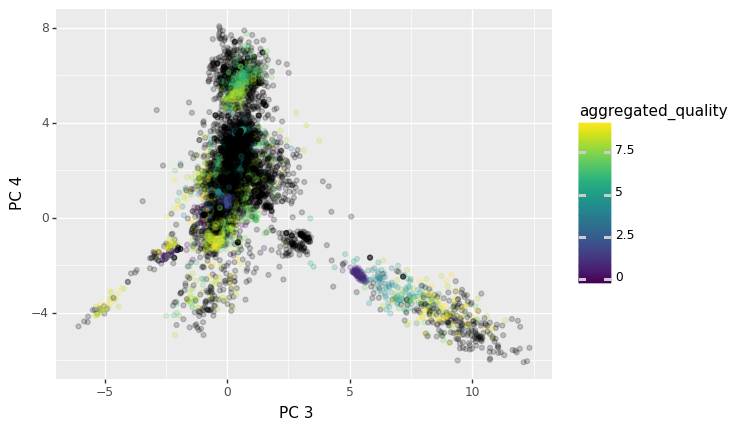

In [3]:
_ = ch.plot(3, 4, bl_rm=False, color='aggregated_quality', alpha=.2).draw()

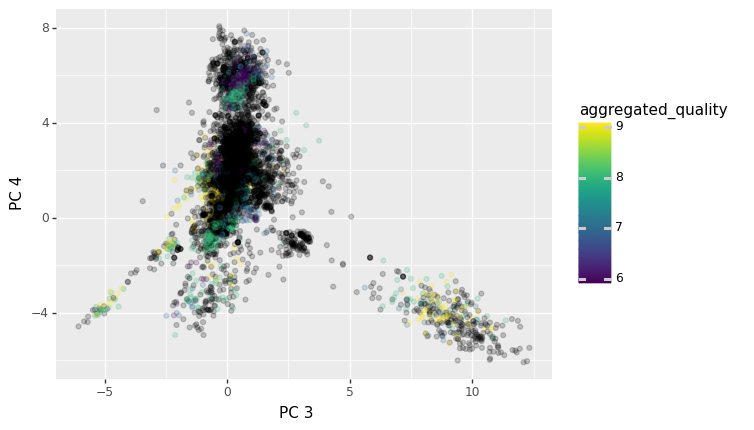

In [4]:
_ = ch.plot(3, 4, bl_rm=True, color='aggregated_quality', alpha=.2).draw()

# $\log(\mathbb E [p])$

We use the Dirichlet distribution to calculate the log of the expected true transcriptome decomposition for each sample.

In [5]:
[ep.shape for ep in ch.expr.log_E_p]

[(116, 16747),
 (1775, 16747),
 (255, 16747),
 (73, 16747),
 (698, 16747),
 (121, 16747),
 (1515, 16747),
 (225, 16747),
 (4799, 16747),
 (894, 16747),
 (1853, 16747),
 (44, 16747),
 (2143, 16747),
 (42, 16747)]

# Dirichlet Sampling

Sampling a fixed number of transcriptom decompositions through the dirichlet distribution. Each cell type has an equal chance of beeing drawn and we sample more samples then we have features so the resulting PCA transformation is a homomorphismus.

In [6]:
dp.transformer

IncrementalPCA(batch_size=None, copy=False, n_components=1000, whiten=True)

### Direct PCA

We fit a PCA on the sampled expressions, apply it on the transformed data set and plot the first 4 components.

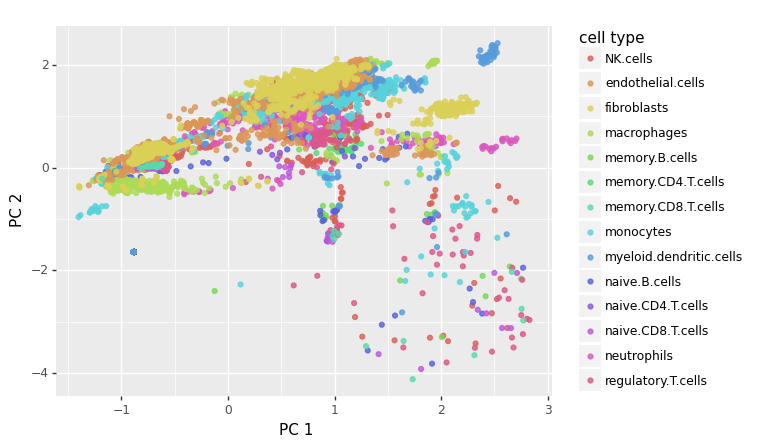

In [7]:
_ = dp.plot(1, 2).draw()

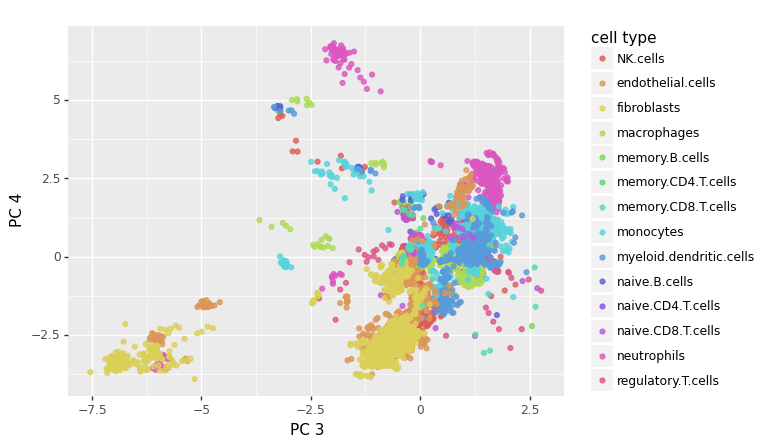

In [8]:
_ = dp.plot(3, 4).draw()

### PCA after whitening

We whiten the data with the first PCA, take the cell type specific average and fit another PCA on the few samples. Than we apply the second PCA on the whole data set and plot the first two components.

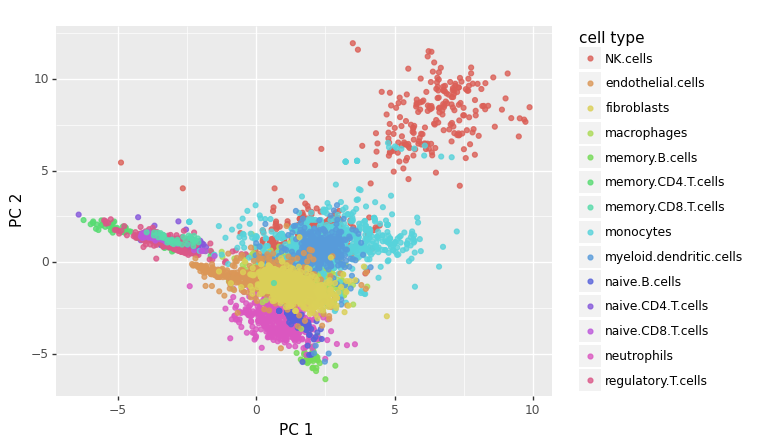

In [9]:
_ = ch.plot(1, 2).draw()

# Fitting Normal Distributions

We fit one multivariate normal distributions per cell type to the dimensionally reduced data to characterise the cell types.

In [10]:
ch.calculate_probs()

# Removing some inconsistencies

Specifically in GSE116672 all samples seem to be NK cells while they are annotated as B cells or cells of the moncytic lineage. These samples are removed and the characterization is fitted again.

In [11]:
dat = ch.data.loc[~ch.blacklisted, :]
dat['coarse.cell.type'].value_counts()

monocytic.lineage    3329
fibroblasts          1998
endothelial.cells    1642
CD4.T.cells           527
neutrophils           499
NK.cells              262
B.cells               142
CD8.T.cells           118
Name: coarse.cell.type, dtype: int64

In [12]:
dat = ch.data.loc[~ch.blacklisted, :]
conf = pd.crosstab(dat['max prop'], dat['cell type'], rownames=['assigned'], colnames=['label'])
conf

label,NK.cells,endothelial.cells,fibroblasts,macrophages,memory.B.cells,memory.CD4.T.cells,memory.CD8.T.cells,monocytes,myeloid.dendritic.cells,naive.B.cells,naive.CD4.T.cells,naive.CD8.T.cells,neutrophils,regulatory.T.cells
assigned,,,,,,,,,,,,,,
NK.cells,241,7,1,2,0,0,0,26,5,0,0,0,0,2
endothelial.cells,0,1504,14,5,0,0,0,0,0,0,0,0,0,0
fibroblasts,0,54,1923,22,0,0,0,4,0,0,0,0,4,0
macrophages,0,8,5,1134,0,0,0,26,10,0,1,0,4,0
memory.B.cells,0,0,0,0,45,0,0,0,3,8,0,0,0,0
memory.CD4.T.cells,0,0,0,0,0,112,0,0,0,0,0,0,0,0
memory.CD8.T.cells,0,0,0,0,0,1,41,0,0,0,0,0,0,18
monocytes,3,7,8,26,0,0,0,1173,12,0,2,0,0,0
myeloid.dendritic.cells,0,4,0,18,0,0,0,138,567,0,0,0,0,0


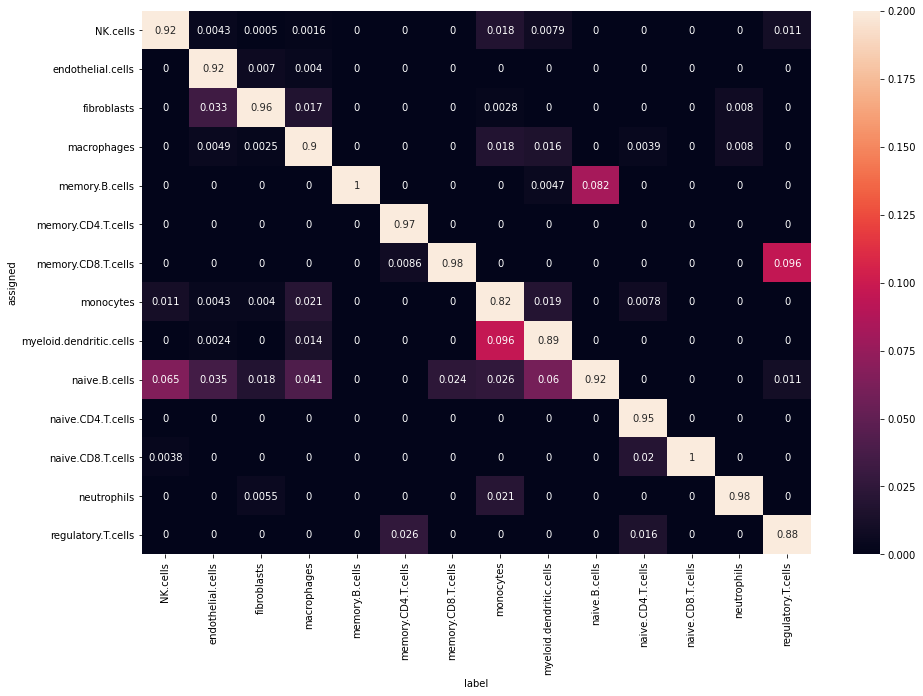

In [13]:
plt.figure(figsize=(15,10))
_ = sn.heatmap(conf/conf.sum(), annot=True, vmin=0, vmax=.2)

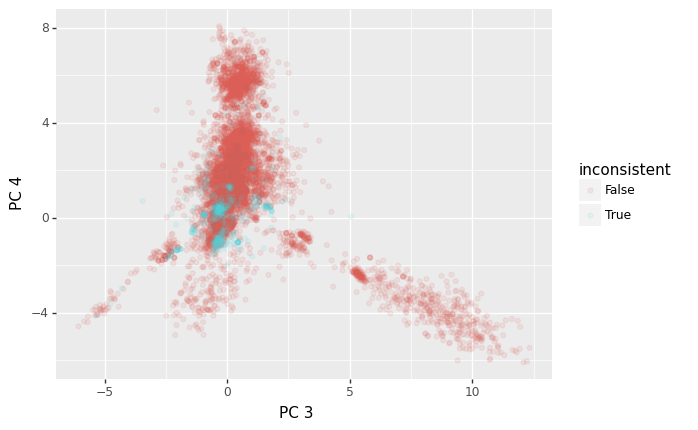

In [14]:
_ = ch.plot(3, 4, color='inconsistent', alpha=.1).draw()

In [15]:
bad_gses = [
    'GSE79706', # most monocytes seem like macrophages
    'GSE41914', # only cohort wrongly classified as naive B-cells while labled as NK-cells
    'GSE116672', # viscRNA-Seq that are very inconsistent
    'GSE66360', # by far most wrongly classified as CD4 T-cells while labled as endothelia cells
    'GSE31312' # by far most wrongly classified as endothelial cells while labled as B-cells
]
dat = ch.data.loc[ch.data['gse'].isin(bad_gses), :]
pd.crosstab( dat['max prop'], dat[f'{grain}.cell.type'], rownames=['assigned'], colnames=['label'])

label,NK.cells,endothelial.cells,macrophages,monocytes,myeloid.dendritic.cells
assigned,,,,,
NK.cells,0,22,0,0,0
macrophages,20,0,19,24,0
monocytes,978,0,0,3315,253
myeloid.dendritic.cells,12,0,0,15,0
naive.B.cells,64,3,0,1,0
neutrophils,0,56,0,0,0
regulatory.T.cells,0,18,0,0,0


In [16]:
ch.blacklisted |= ch.data['gse'].isin(bad_gses)
ch.calculate_probs()

In [17]:
dat = ch.data.loc[~ch.blacklisted, :]
gses = pd.crosstab(dat['gse'], dat['inconsistent'])
gses['size'] = gses.sum(axis=1)
gses['consistency'] = gses[True] / gses['size']
gses['bad'] = gses[False] == 0

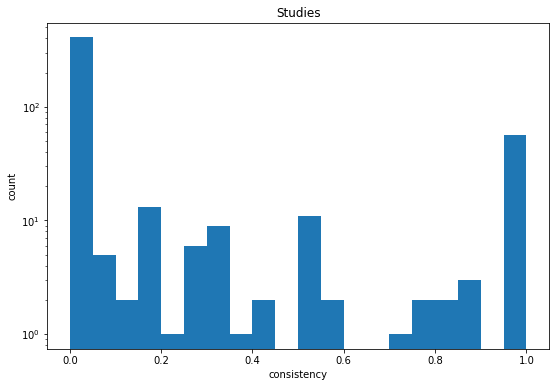

In [18]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111)
ax1.set_title('Studies')
ax1.set_ylabel('count')
ax1.set_xlabel('consistency')
plt.yscale('log')
gses['consistency'].hist(bins=20, grid=False)

In [19]:
sum(ch.data['gse'].isin(gses.index[gses['bad']])) / len(ch.data['gse'])

0.03222703222703223

In [20]:
ch.blacklisted |= ch.data['gse'].isin(gses.index[gses['bad']])

# Check inconsistencies after removal

In [21]:
ch.calculate_probs()

In [22]:
dat = ch.data.loc[~ch.blacklisted, :]
conf = pd.crosstab(dat['max prop'], dat['cell type'], rownames=['assigned'], colnames=['label'])
conf

label,NK.cells,endothelial.cells,fibroblasts,macrophages,memory.B.cells,memory.CD4.T.cells,memory.CD8.T.cells,monocytes,myeloid.dendritic.cells,naive.B.cells,naive.CD4.T.cells,naive.CD8.T.cells,neutrophils,regulatory.T.cells
assigned,,,,,,,,,,,,,,
NK.cells,241,4,0,2,0,0,0,24,4,0,0,0,0,1
endothelial.cells,0,1504,4,5,0,0,0,0,0,0,0,0,0,0
fibroblasts,0,25,1923,0,0,0,0,4,0,0,0,0,0,0
macrophages,0,5,1,1134,0,0,0,8,10,0,1,0,4,0
memory.B.cells,0,0,0,0,45,0,0,0,3,8,0,0,0,0
memory.CD4.T.cells,0,0,0,0,0,112,0,0,0,0,0,0,0,0
memory.CD8.T.cells,0,0,0,0,0,1,41,0,0,0,0,0,0,18
monocytes,1,5,3,17,0,0,0,1173,2,0,2,0,0,0
myeloid.dendritic.cells,0,4,0,12,0,0,0,20,567,0,0,0,0,0


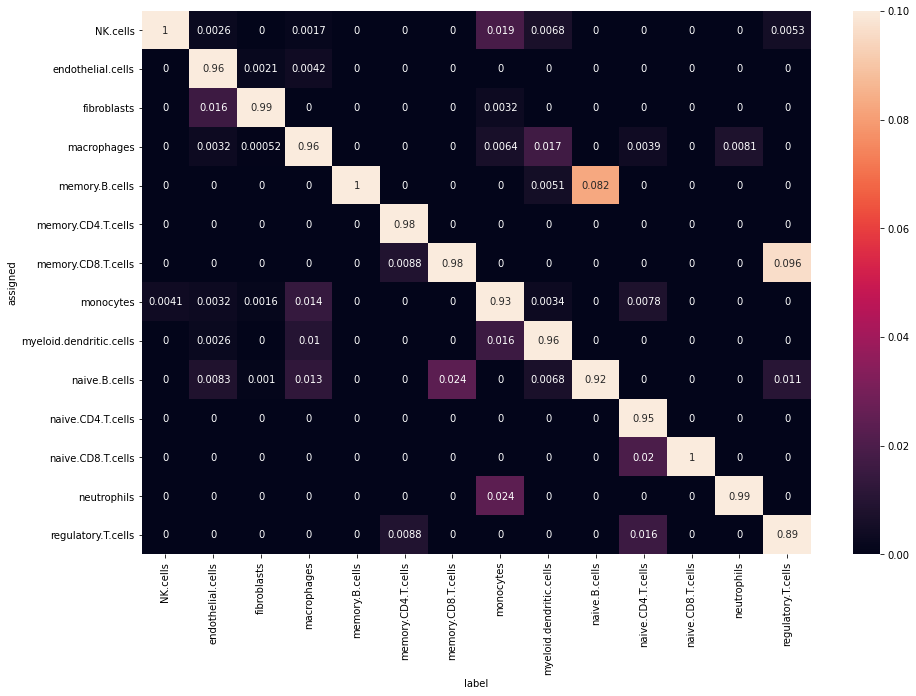

In [23]:
plt.figure(figsize=(15,10))
_ = sn.heatmap(conf/conf.sum(), annot=True, vmin=0, vmax=.1)

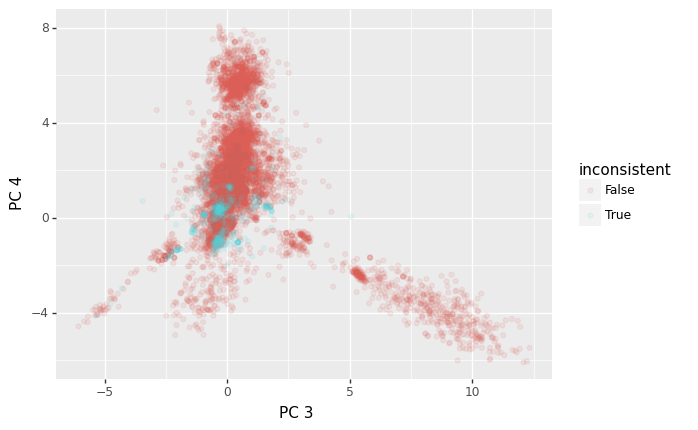

In [24]:
_ = ch.plot(3, 4, color='inconsistent', alpha=.1).draw()

# Inspecting Distributions

Visually checking the resulting distributions.

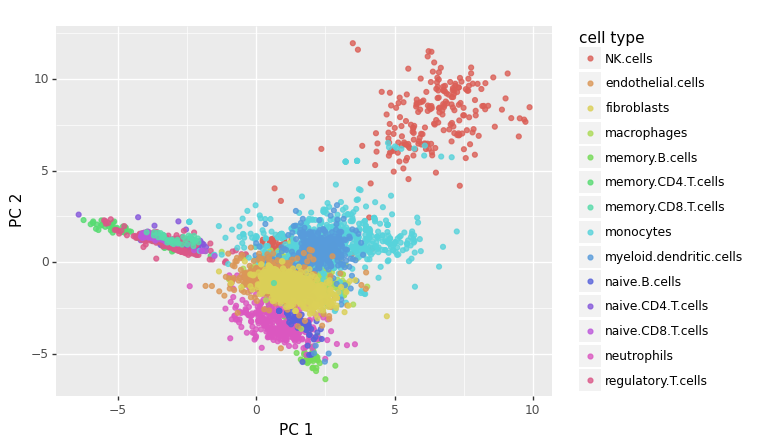

In [25]:
_ = ch.plot(1, 2, bl_rm=True).draw()

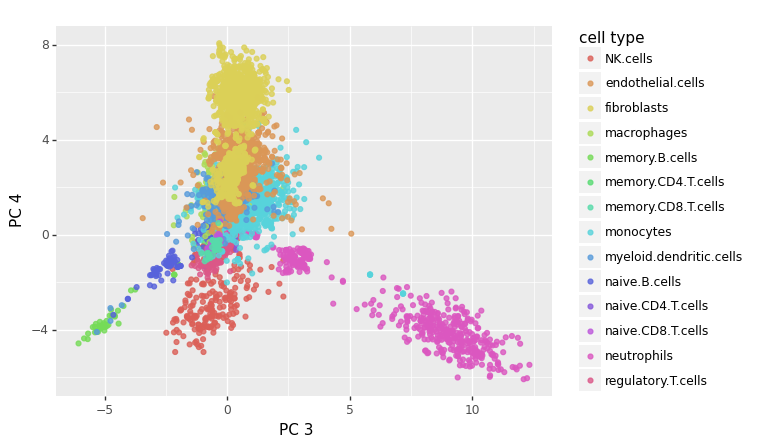

In [26]:
_ = ch.plot(3, 4, bl_rm=True).draw()

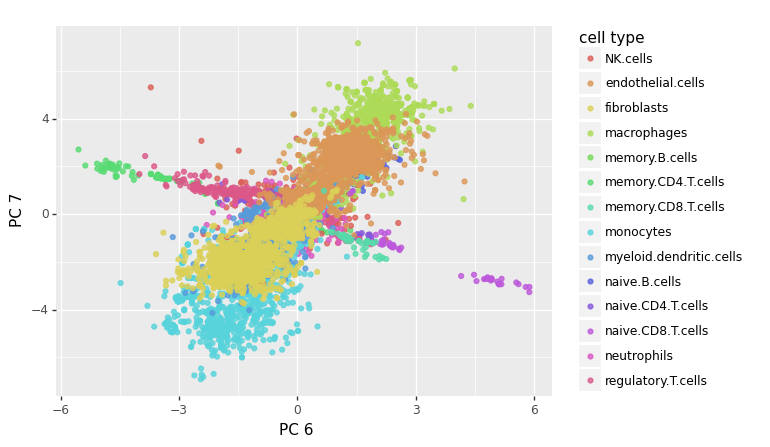

In [27]:
_ = ch.plot(6, 7, bl_rm=True).draw()

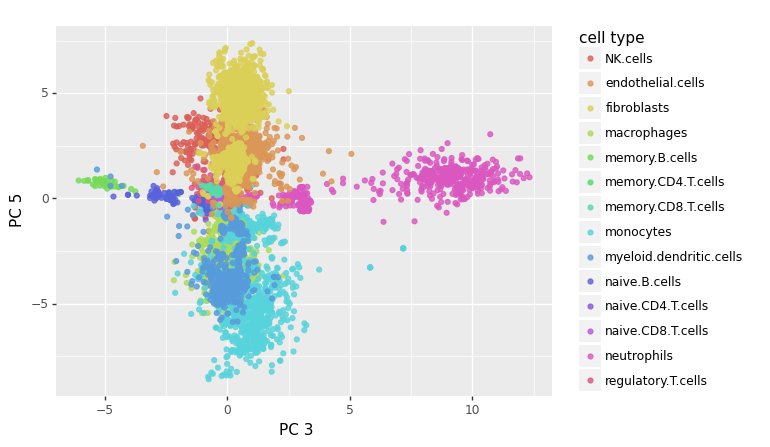

In [28]:
_ = ch.plot(3, 5, bl_rm=True).draw()

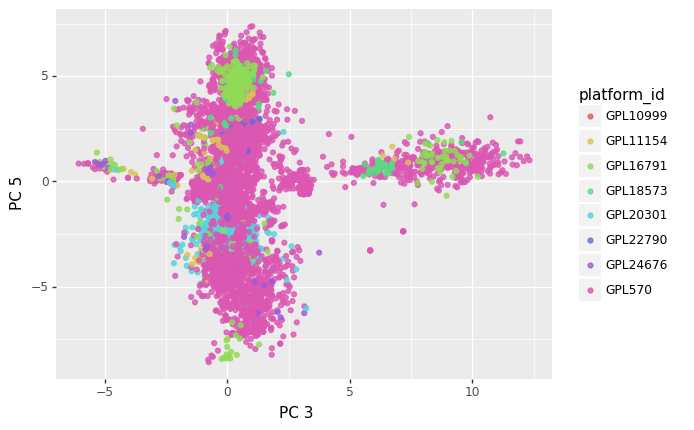

In [29]:
_ = ch.plot(3, 5, color='platform_id').draw()

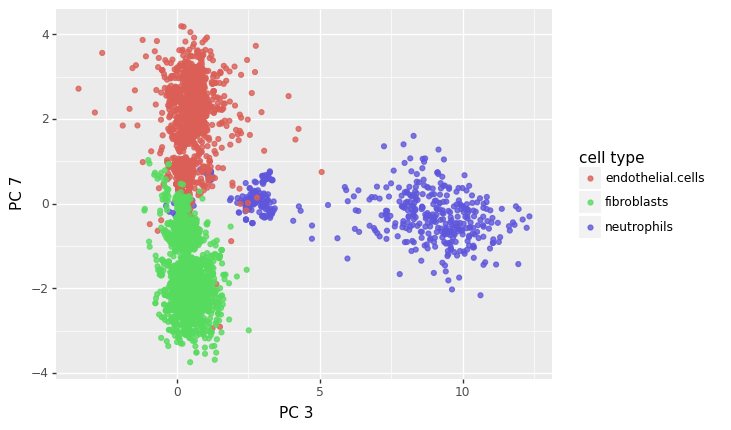

In [30]:
_ = ch.plot(3, 7, ['endothelial.cells', 'fibroblasts', 'neutrophils', 'monocytic.lineage'], bl_rm=True).draw()

# Prepare transformation

To sample from the cell type characterisation space and evaluate the measurment likelihood we need the affine transformation from the subspace into the the space of all features given by
$$
h(x) = xA^{-1}+b
$$
where $A^{-1}$ is a pseudo inverse of the PCA matrix $A$ such that $A^{-1}A=I$ but $AA^{-1}\neq I$ due to the lack of full rank and it will be called `Ainv`.

In [31]:
b, A, Ainv = ch.affine_trans

The statistics below are required for the mcmc that samples deviations from the margin.

In [32]:
variations = ch.get_remaining_variation()

In [33]:
backgrounds = ch.background_chars

# Saving Results

In [34]:
chars_file_name = ('../data/genchar_' + grain + '_'+out_tag+'.pkl')
chars_data = dict({'A':A, 'Ainv':Ainv, 'b':b, 'chars':ch.chars, 'backgrounds':backgrounds,
                   'features':ch.expr.features, 'variations':variations})
with open(chars_file_name, 'wb') as buff:
    pickle.dump(chars_data, buff, protocol=4)

In [35]:
file_name = '../data/transformations_'+grain+'_'+out_tag+'.pkl'
data = dict({'A':A, 'Ainv':Ainv, 'b':b, 'test_counts':expr.test_counts, 'variations':variations, 'ch':ch})
with open(file_name, 'wb') as buff:
    pickle.dump(data, buff, protocol=4)

# Resampling

Since we only have few samples for some cell types, the characterization my not be very accurate. We can improve a little bit by resampling from the measurement uncertainty. Since it is sampled from a Dirichlet distribution it may have an impact on means and covariance of the fitted multivariate normal distribution. We want to model which experssion pattern a new sample might have and since it is subject to the same measurement noise, we have to take the noise into account. Cell types with large sample sizes already represent measurement and biological variation but small samples lack both. We cannot guess biological variation but at least take the measurement uncertainty into account.

In [36]:
newexpr = ResampledExperssions(expr, blacklist = list(ch.blacklisted.index[ch.blacklisted]))
ch2 = Characterizer(dp, expressions=newexpr)

Doing memory.CD4.T.cells ...
Doing NK.cells ...
Doing naive.CD4.T.cells ...
Doing memory.B.cells ...
Doing neutrophils ...
Doing naive.B.cells ...
Doing macrophages ...
Doing regulatory.T.cells ...
Doing monocytes ...
Doing myeloid.dendritic.cells ...
Doing endothelial.cells ...
Doing naive.CD8.T.cells ...
Doing fibroblasts ...
Doing memory.CD8.T.cells ...


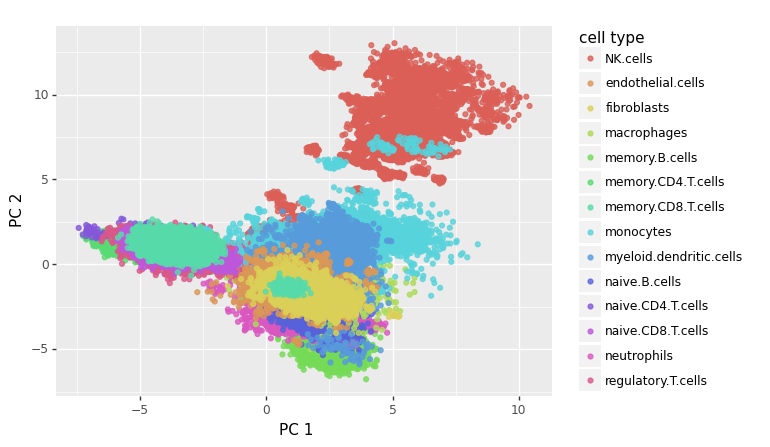

In [37]:
_ = ch2.plot(1, 2, bl_rm=True).draw()

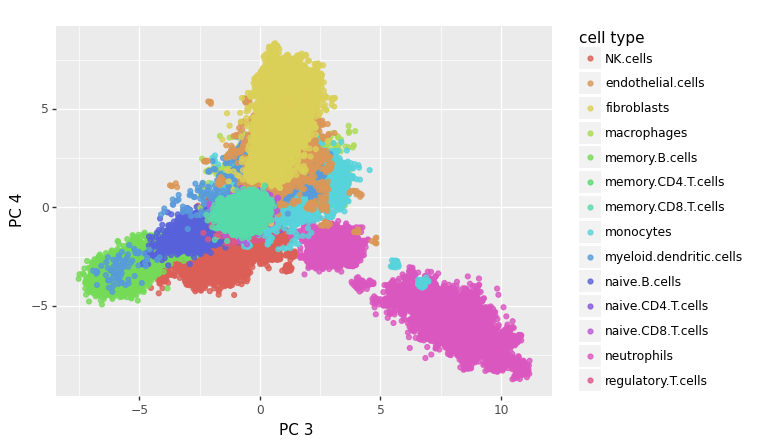

In [38]:
_ = ch2.plot(3, 4, bl_rm=True).draw()

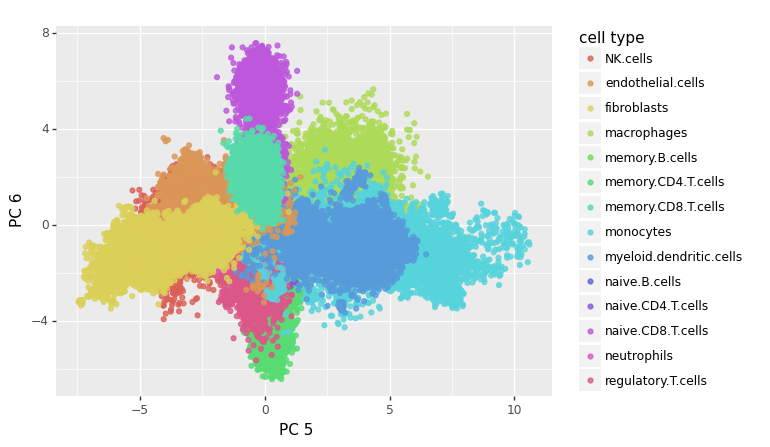

In [39]:
_ = ch2.plot(5, 6, bl_rm=True).draw()

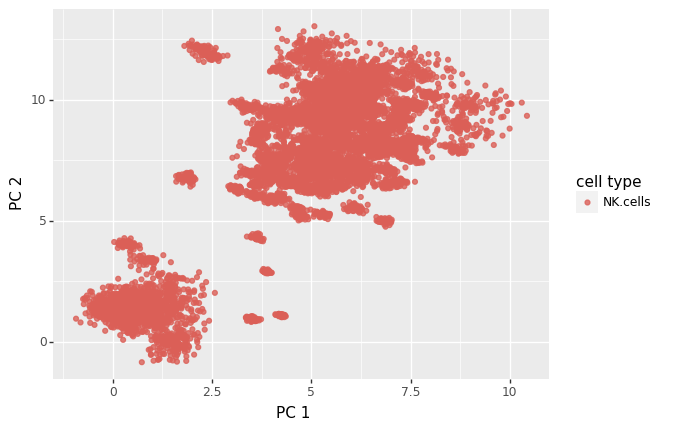

In [40]:
_ = ch2.plot(1, 2, ['NK.cells', 'CD4.T.cells', 'CD8.T.cells', 'B.cells'], bl_rm=True).draw()

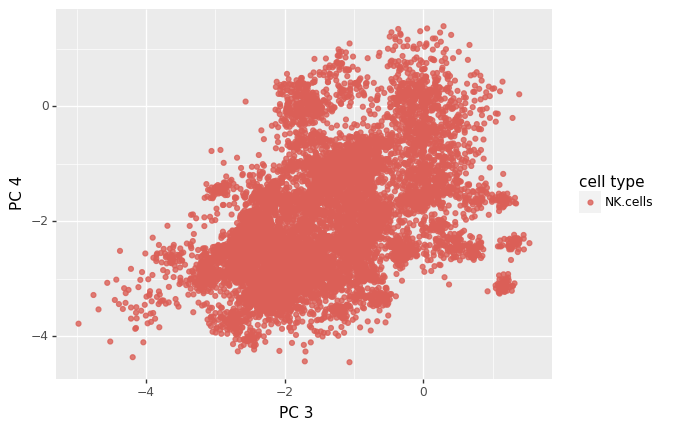

In [41]:
_ = ch2.plot(3, 4, ['NK.cells', 'CD4.T.cells', 'CD8.T.cells', 'B.cells'], bl_rm=True).draw()

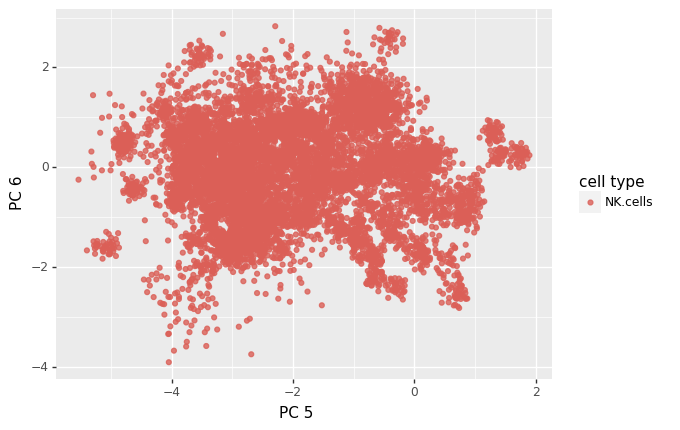

In [42]:
_ = ch2.plot(5, 6, ['NK.cells', 'CD4.T.cells', 'CD8.T.cells', 'B.cells'], bl_rm=True).draw()

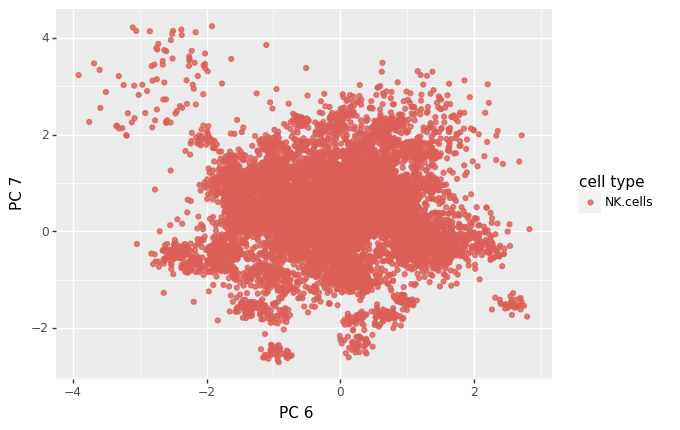

In [43]:
_ = ch2.plot(6, 7, ['NK.cells', 'CD4.T.cells', 'CD8.T.cells', 'B.cells'], bl_rm=True).draw()

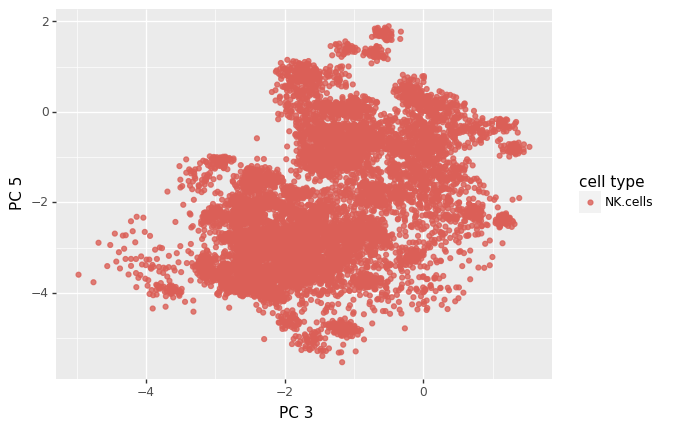

In [44]:
_ = ch2.plot(3, 5, ['NK.cells', 'CD4.T.cells', 'CD8.T.cells', 'B.cells'], bl_rm=True).draw()

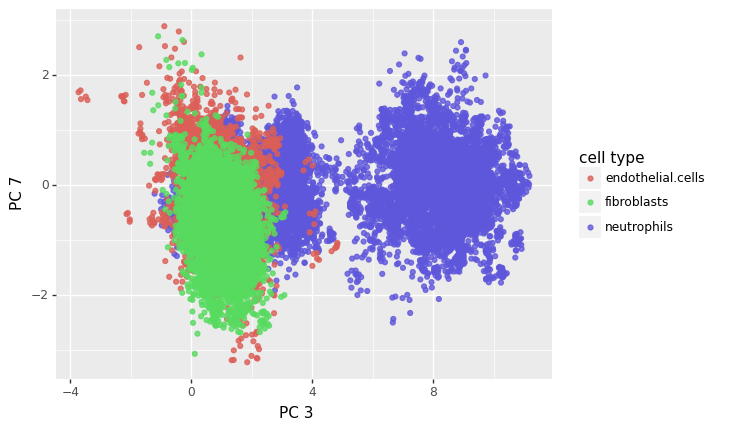

In [45]:
_ = ch2.plot(3, 7, ['endothelial.cells', 'fibroblasts', 'neutrophils', 'monocytic.lineage'], bl_rm=True).draw()

In [46]:
ch2.calculate_probs()
confr = pd.crosstab(ch2.data['max prop'], ch2.data['cell type'], rownames=['assigned'], colnames=['label'])
confr

label,NK.cells,endothelial.cells,fibroblasts,macrophages,memory.B.cells,memory.CD4.T.cells,memory.CD8.T.cells,monocytes,myeloid.dendritic.cells,naive.B.cells,naive.CD4.T.cells,naive.CD8.T.cells,neutrophils,regulatory.T.cells
assigned,,,,,,,,,,,,,,
NK.cells,9910,13,0,6,0,0,0,159,56,4,0,0,11,16
endothelial.cells,8,9599,70,48,0,0,0,2,3,10,6,0,0,0
fibroblasts,0,140,9899,8,0,0,0,30,1,2,0,0,0,0
macrophages,4,40,9,9438,3,0,0,92,214,101,17,10,3,0
memory.B.cells,0,0,0,0,9787,0,0,0,80,586,2,0,5,0
memory.CD4.T.cells,0,0,0,0,0,9275,1,7,0,0,11,1,0,26
memory.CD8.T.cells,1,0,0,0,0,520,9652,0,0,2,35,93,0,980
monocytes,76,34,11,131,2,0,0,9424,44,1,2,0,0,0
myeloid.dendritic.cells,0,28,0,148,3,0,0,67,9513,4,0,0,0,0


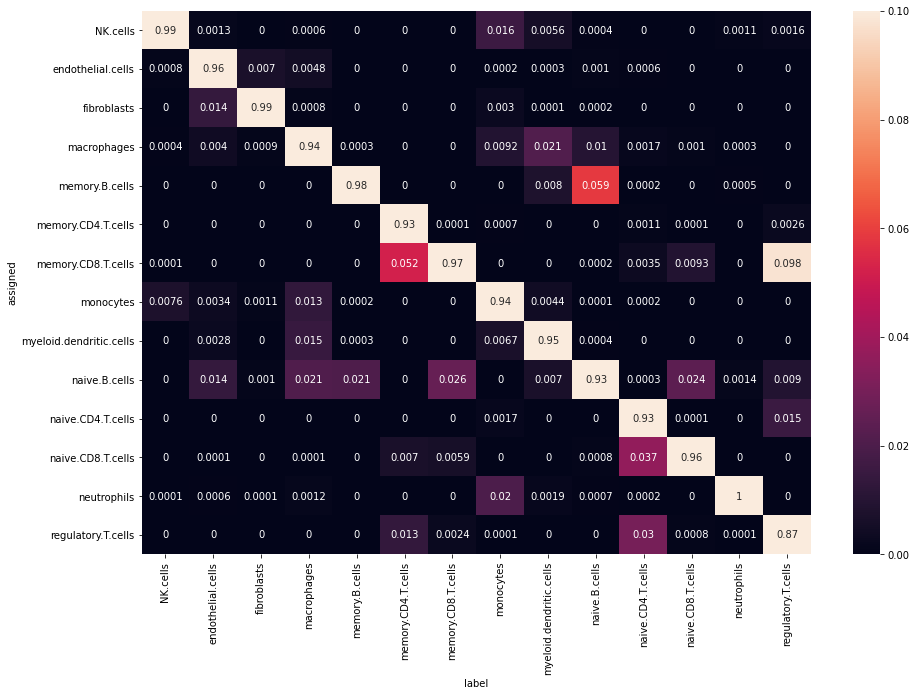

In [47]:
plt.figure(figsize=(15,10))
_ = sn.heatmap(confr/confr.sum(), annot=True, vmin=0, vmax=.1)

In [48]:
r_variations = ch2.get_remaining_variation()
r_backgrounds = ch2.background_chars
chars_file_name = ('../data/genchar_' + grain + '_'+out_tag+'r.pkl')
r_b, r_A, r_Ainv = ch2.affine_trans
chars_data = dict({'A':r_A, 'Ainv':r_Ainv, 'b':r_b, 'chars':ch2.chars, 'backgrounds':r_backgrounds,
                   'features':ch2.expr.features, 'variations':r_variations})
with open(chars_file_name, 'wb') as buff:
    pickle.dump(chars_data, buff, protocol=4)

# Test Transformations
To test if all transformations are valid, we go through:

$$
\tau^{-1} \circ \log(\mathbb E[p]) \xrightarrow[]{\text{softmax}} \mathbb E[p]
\xrightarrow[]{\log} \log(\mathbb E[p]) \xrightarrow[]{\text{combined affine trans}} \text{Principal Components}
$$
and compare the result to the data that was transformed iterativly. We do this only for NK cells. Since all data is treated equally the transformation is correct if it is correct for NK cells.

In [49]:
from scipy.special import softmax
X = np.log(softmax(expr.tau_projected_values[0]))
nc = np.dot((X - b), A) # no tau projection needed
pDat = pd.DataFrame(nc)
pDat.columns = list(ch.coords.columns)
pDat['cell type'] = 'cust'

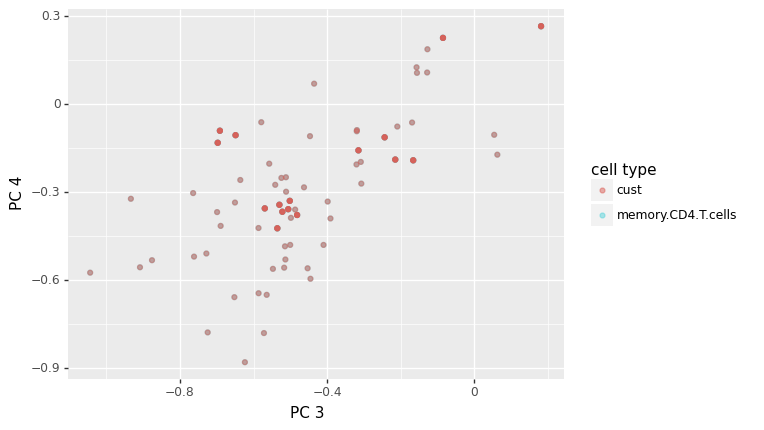

In [50]:
mdata = pd.concat([ch.plot_data, pDat], axis=0, sort=False)
key = expr.cell_types[0]
_ = ch.plot(3, 4, [key, 'cust'], data=mdata, alpha=.5).draw()

The data seems identical, now what is left to show that the combined affine transformation
$$
h^{-1}(y) = (x-b)\cdot A
$$
is pseudoinverse inverse to
$$
h(x) = xA^{-1}+b
$$
so we check if $A^{-1}\cdot A$ is close to the identity matrix $I$:

In [51]:
np.all(np.isclose(np.dot(Ainv, A), np.identity(A.shape[1])))

True

# Test Dimensionality

We check the classification accuracy for multiple compressions / number of dimensions.